# Prediction of Goals in Football using Expected Goals


# Installing and Importing the required Libraries 

Installing `mplsoccer`, a library used for football data visualization   

In [ ]:
!pip install mplsoccer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for mplsoccer: filename=mplsoccer-1.0.6-py3-none-any.whl size=62946 sha256=a69cfc585896d0a0fef7921e5547c48fc6c914d187228ef24a465899c3f34b52
  Stored in directory: /root/.cache/pip/wheels/ff/fc/ed/09e6cb7c61780f5462f1dfd1df7d1fabef0123ced961ac0738
Successfully built mplsoccer


In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import mplsoccer
import pydot
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,plot_roc_curve,f1_score
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable
from io import StringIO
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

# Explaining the Data

To build ax xG Model, we need shot data of a good sample size.<br>
Football data is usually of two types:
* Event Data
* Tracking Data

Event data comprises of all the on-the-ball actions/events (like pass, dribble, shot, tackle etc.) that occur and their locations on the pitch.<br>
Tracking Data, on the other hand, keeps track of locations and actions of all the 22 players on pitch and the ball, for every 1/10th of a second. Tracking Data of a single match consists of millions of rows. It is mostly used by the analytics companies and analytics departments of the football clubs and isn't available to the public.<br><br>

For this project, we are using event data extracted from Understat's website. It has all the shots taken by all the teams the Top 5 European Leagues from 2014-2020. It has data recorded for approximately 300,000 shots.<br>
It has records of the X & Y coordinates of the shots on a pitch of size *1x1*, situation from which the shot arises, the type of shot, the last action before the shot was taken.


# Loading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path='Data/ShotsData.csv'
df = pd.read_csv(path)

In [ ]:
pd.set_option('max_columns',20)

In [ ]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,TrÃ©zÃ©guet,Cross
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross


# Data Pre-Processing 

Checking for any null values

In [ ]:
df.isnull().values.any()

True

In [ ]:
df.isnull().sum()

id                     0
minute                 0
result                 0
X                      0
Y                      0
xG                     0
player                 0
h_a                    0
player_id              0
situation              0
year                   0
shotType               0
match_id               0
h_team                 0
a_team                 0
h_goals                0
a_goals                0
date                   0
player_assisted    77672
lastAction             0
dtype: int64

As all the null values come from player_assisted column and we will not be using it for creating out Machine Learning model, we drop it.

In [ ]:
df.drop(columns='player_assisted',inplace=True)

Dropping the default xG column as we need to calculate xG

In [ ]:
df.drop(columns='xG',inplace=True)

Multiplying X & Y values with 100 to convert the coordinates into *100x100* get a better plot 

In [ ]:
df[['X','Y']] = df[['X','Y']]*100

Removing the shots which are `Blocked` by opposition defenders (since we do not have the location of the defenders) and shots which are resulted into `Own Goals`

In [ ]:
df = df[~((df['result']=='BlockedShot')|(df['result']=='OwnGoal'))]

Creating the target variable called `isGoal`

In [ ]:
df['isGoal'] = np.where(df['result']=='Goal',1,0)

The following image shows what Shot Angle is.<br>

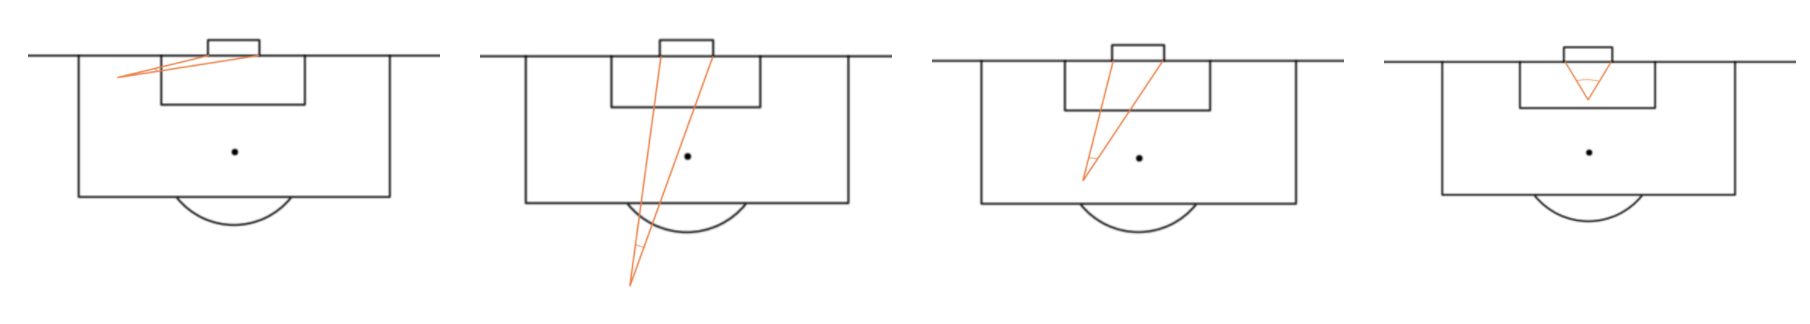

Creating a function called `calcAngle` to calculate the shot angle to the goal mouth

In [ ]:
def calcAngle(x,y):
    b = np.array([x,y])
    # (100,45) and (100,55) are the coordinates of the left and right bars of the goal-post 
    a = np.array([100,45]) 
    c = np.array([100,55])
    ba = a-b
    bc = c-b
    # Calculating the angle using the vector cosine formula
    cosAngle = np.dot(ba,bc)/(np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosAngle)
    return np.degrees(angle)

In [ ]:
df['Angle'] = df.apply(lambda x:calcAngle(x['X'],x['Y']),axis=1)

Calculating distance of the shots from the center of the goal

In [ ]:
df['DistanceFromGoal'] = np.sqrt(np.square(100-df['X'])+np.square(50-df['Y'])) # (100,50) are the coordinates of center of the goal

Checking for all the unique values in `lastAction`

In [ ]:
df['lastAction'].value_counts()

Pass               72941
Cross              35457
None               23408
Aerial             17505
Standard           12721
Chipped            12624
TakeOn             11346
Rebound             9380
HeadPass            5632
Throughball         5486
BallRecovery        4905
BallTouch           2843
LayOff              2026
Dispossessed        1098
Tackle               491
Interception         303
BlockedPass          239
Foul                 224
CornerAwarded        123
Goal                 110
End                   95
GoodSkill             49
OffsidePass           36
Clearance             31
Challenge             27
SubstitutionOn        27
Card                  25
Save                  10
Start                 10
KeeperPickup           6
FormationChange        5
Error                  5
ChanceMissed           2
SubstitutionOff        1
KeeperSweeper          1
OffsideProvoked        1
ShieldBallOpp          1
Punch                  1
Smother                1
Name: lastAction, dtype: 

Changing all the names of `lastAction` values which appear less than 500 times into `OtherActions` since there are too many unique `lastAction` values.

In [ ]:
lastActionsIndexes = df['lastAction'].value_counts()<500
df.loc[df['lastAction'].isin(lastActionsIndexes.index[lastActionsIndexes]),'lastAction'] = 'OtherActions'

# Exploratory Data Analysis

In [ ]:
dfViz = df.copy()

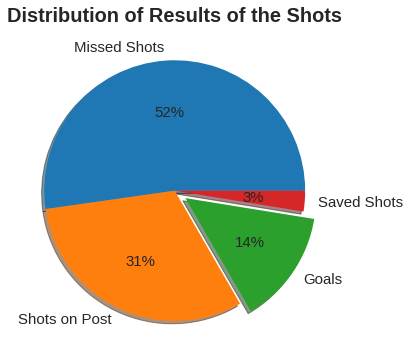

In [ ]:
results = dfViz['result'].value_counts().to_dict()
dfResults = pd.DataFrame(results.items(),columns=['Result','Count'])
# Plotting a Pie Chart of the Results of the Shot
fig,ax = plt.subplots(figsize=(8,6))
plt.pie(dfResults['Count'],explode=(0,0,0.1,0),shadow=True,textprops={'fontsize':15},
        labels=['Missed Shots','Shots on Post','Goals','Saved Shots'],autopct='%.0f%%')
plt.title('Distribution of Results of the Shots',fontsize=20,fontweight='bold')
plt.show()

**Inference** : Only 14% of the the shots taken by the players are successfully converted into goals.

In [ ]:
situation = dfViz['situation'].value_counts().to_dict()
situationG = dfViz[dfViz['isGoal']==1]['situation'].value_counts().to_dict()

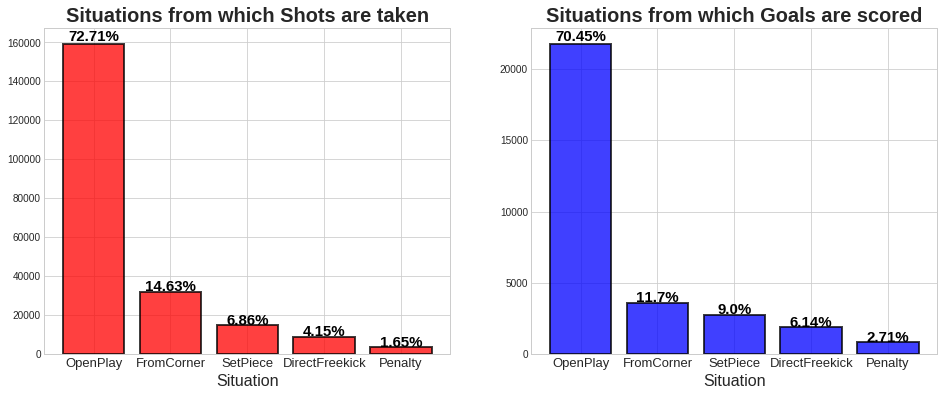

In [ ]:
# Plotting bar charts to show in which situations shots and goals come from
fig,axs = plt.subplots(1,2,figsize=(16,6))
axs[0].bar(situation.keys(),situation.values(),edgecolor='k',linewidth=2,color='red',alpha=.75)
axs[0].set_xlabel('Situation',fontsize=16)
axs[0].set_xticklabels(situation.keys(),fontsize=13)
axs[0].set_title('Situations from which Shots are taken',fontsize=20,fontweight='bold')
for key,value in situation.items():
    axs[0].text(key,value+0.01*value,
                str(round(value*100/sum(situation.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)

axs[1].bar(situationG.keys(),situationG.values(),edgecolor='k',linewidth=2,color='blue',alpha=.75)
axs[1].set_xlabel('Situation',fontsize=16)
axs[1].set_xticklabels(situation.keys(),fontsize=13)
axs[1].set_title('Situations from which Goals are scored',fontsize=20,fontweight='bold')
for key,value in situationG.items():
    axs[1].text(key,value+0.01*value,
                str(round(value*100/sum(situationG.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)

plt.show()

**Inference** : According to the distribution above, around 70% of the shots and goals come from open play situations, while the remaining come from dead ball situations like corners, set pieces, freekicks and penalties

In [ ]:
dfSitShot = pd.DataFrame(situation.items(),columns=['Situation','ShotCount'])
dfSitGoal = pd.DataFrame(situationG.items(),columns=['Situation','GoalCount'])
dfSit = dfSitShot.merge(dfSitGoal,on='Situation')
dfSit['Conversion'] = (dfSit['GoalCount']/dfSit['ShotCount'])*100

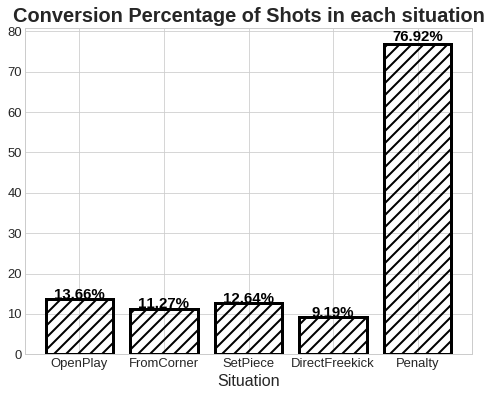

In [ ]:
# Plotting bar chart to show conversion rate of shot to goal in each situation
mpl.rcParams['hatch.linewidth'] = 2
plt.figure(figsize=(8,6))
plt.bar(dfSit['Situation'],dfSit['Conversion'],linewidth=3,edgecolor='k',color='None',hatch='//')
plt.xlabel('Situation',fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Conversion Percentage of Shots in each situation',fontsize=20,fontweight='bold')
for idx,row in dfSit.iterrows():
    plt.text(dfSit['Situation'][idx],dfSit['Conversion'][idx]+0.01*dfSit['Conversion'][idx],
                str(round(dfSit['Conversion'][idx],2))+'%',
                c='k',fontweight='bold',ha='center',size=15)

plt.show()

**Inference** : <br>
The rate at which shots are converted into goals is around 9-14% in all situations except penalties. <br>
For penalties, the conversion rate is nearly 77%. This is because,
* There will not be any opposition defenders blocking the shot during the penalties apart from the GoalKeeper.
* Also the shot location and shot angle for the penalties is fixed and optimal for scoring goals.

In [ ]:
shotPart = dfViz['shotType'].value_counts().to_dict()
shotPartG = dfViz[dfViz['isGoal']==1]['shotType'].value_counts().to_dict()

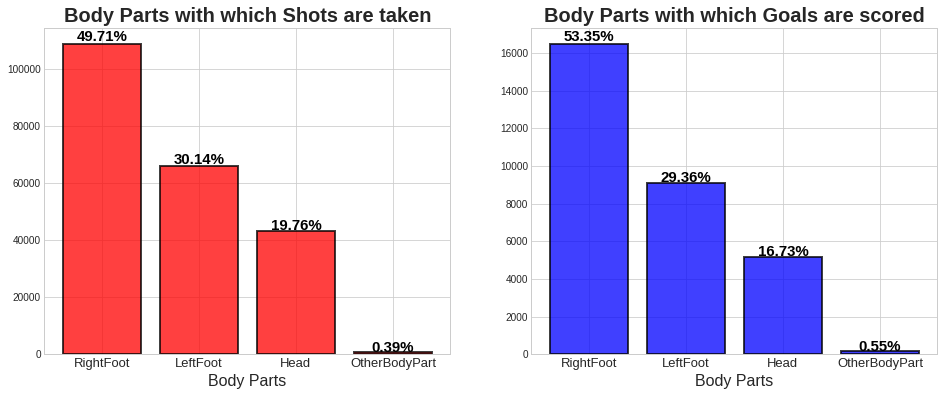

In [ ]:
# Plotting bar charts to show with which body part shots and goals are taken with
fig,axs = plt.subplots(1,2,figsize=(16,6))
axs[0].bar(shotPart.keys(),shotPart.values(),edgecolor='k',linewidth=2,color='red',alpha=.75)
axs[0].set_xlabel('Body Parts',fontsize=16)
axs[0].set_xticklabels(shotPart.keys(),fontsize=13)
axs[0].set_title('Body Parts with which Shots are taken',fontsize=20,fontweight='bold')
for key,value in shotPart.items():
    axs[0].text(key,value+0.01*value,
                str(round(value*100/sum(shotPart.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)


axs[1].bar(shotPartG.keys(),shotPartG.values(),edgecolor='k',linewidth=2,color='blue',alpha=.75)
axs[1].set_xlabel('Body Parts',fontsize=16)
axs[1].set_xticklabels(shotPart.keys(),fontsize=13)
axs[1].set_title('Body Parts with which Goals are scored',fontsize=20,fontweight='bold')
for key,value in shotPartG.items():
    axs[1].text(key,value+0.01*value,
                str(round(value*100/sum(shotPartG.values()),2))+'%',
                c='k',fontweight='bold',ha='center',size=15)


plt.show()

**Inference** : <br>
* Players use their feet for nearly 80-85% of their shots and goals.
* In the remaining 15-20%, they use their head and very rarely other body parts which include Torso and Shoulder. 

In [ ]:
lastAction = dfViz['lastAction'].value_counts().to_dict()
lastActionG = dfViz[dfViz['isGoal']==1]['lastAction'].value_counts().to_dict()

In [ ]:
dfLastAction = pd.DataFrame(lastAction.items(),columns=['LastAction','Count'])
dfLastActionG = pd.DataFrame(lastActionG.items(),columns=['LastAction','Count'])

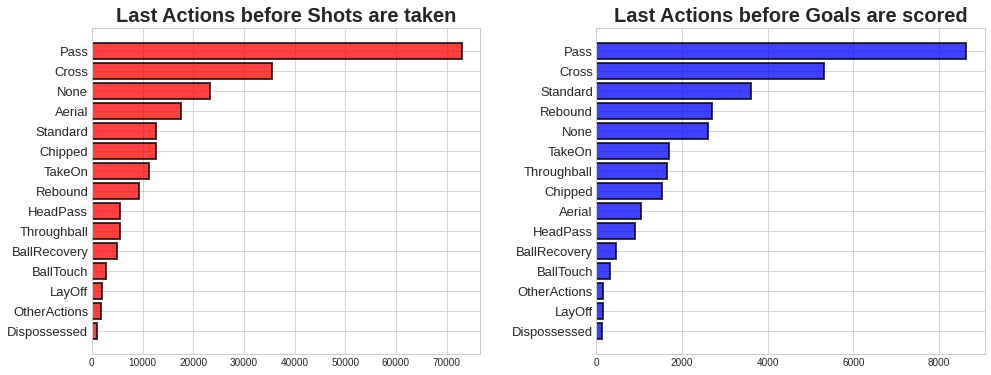

In [ ]:
# Plotting bar charts to show the last actions before shots and goals
fig,axs = plt.subplots(1,2,figsize=(16,6))
plt.subplots_adjust(wspace=.3)

axs[0].barh(dfLastAction['LastAction'],dfLastAction['Count'],edgecolor='k',linewidth=2,color='red',alpha=.75)
axs[0].set_yticklabels(lastAction.keys(),fontsize=13)
axs[0].set_title('Last Actions before Shots are taken',fontsize=20,fontweight='bold')
axs[0].invert_yaxis()

axs[1].barh(dfLastActionG['LastAction'],dfLastActionG['Count'],edgecolor='k',linewidth=2,color='blue',alpha=.75)
axs[1].set_yticklabels(lastActionG.keys(),fontsize=13)
axs[1].set_title('Last Actions before Goals are scored',fontsize=20,fontweight='bold')
axs[1].invert_yaxis()

plt.show()

**Inference** : The last action before most of the shots and goals are usually either passes or crosses.

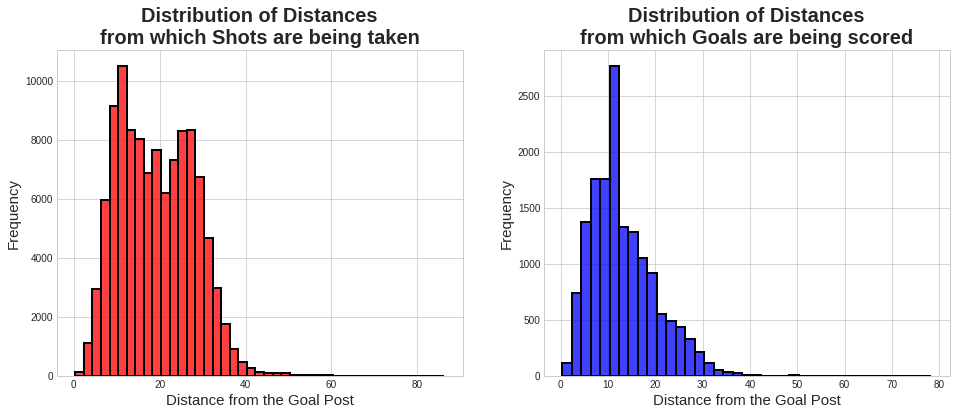

In [ ]:
# Plotting bar charts to show distribution of distance from goal for Shots and Goals
fig,axs = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x='DistanceFromGoal',binwidth=2,data=dfViz,stat='frequency',
             color='red',alpha=.75,lw=2,ax=axs[0])
axs[0].set_xlabel('Distance from the Goal Post',fontsize=15)
axs[0].set_ylabel('Frequency',fontsize=15)
axs[0].set_title('Distribution of Distances\nfrom which Shots are being taken',fontsize=20,fontweight='bold')

dfGViz = dfViz[dfViz['isGoal']==1]
sns.histplot(x='DistanceFromGoal',binwidth=2,data=dfGViz,stat='frequency',
             color='blue',alpha=.75,lw=2,ax=axs[1])
axs[1].set_xlabel('Distance from the Goal Post',fontsize=15)
axs[1].set_ylabel('Frequency',fontsize=15)
axs[1].set_title('Distribution of Distances\nfrom which Goals are being scored',fontsize=20,fontweight='bold')

plt.show()

**Inference** : <br>
* There is a high frequency of shots from 5-35 units distance from the goal.
* There is high frequency of goals being scored from 5-20 units distance from the goal.
* There are a very few shots which are taken from less than 5 units and more than 40 units distance away from the goal.

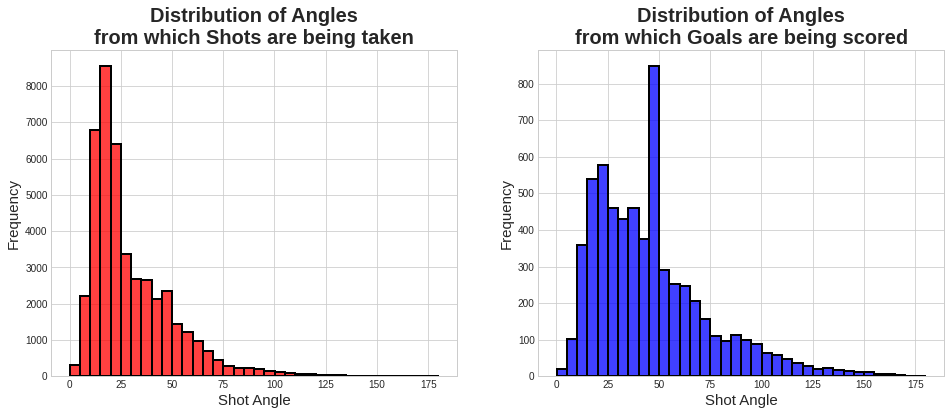

In [ ]:
# Plotting bar charts to show distribution of Ahot Angle for Shots and Goals
fig,axs = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x='Angle',binwidth=5,data=dfViz,stat='frequency',
             color='red',alpha=.75,lw=2,ax=axs[0])
axs[0].set_xlabel('Shot Angle',fontsize=15)
axs[0].set_ylabel('Frequency',fontsize=15)
axs[0].set_title('Distribution of Angles\nfrom which Shots are being taken',fontsize=20,fontweight='bold')

sns.histplot(x='Angle',binwidth=5,data=dfGViz,stat='frequency',
             color='blue',alpha=.75,lw=2,ax=axs[1])
axs[1].set_xlabel('Shot Angle',fontsize=15)
axs[1].set_ylabel('Frequency',fontsize=15)
axs[1].set_title('Distribution of Angles\nfrom which Goals are being scored',fontsize=20,fontweight='bold')

plt.show()

**Inference** : <br>
* There is a high frequency of shots from 15-30 degrees of Shot Angle with resepct to the Goal Post.
* There is high frequency of goals being scored from 20-50 degrees of Shot Angle with resepct to the Goal Post.
* Players rarely take shots when their shot angle is less than 5 degrees or more than 75 degrees.

In [ ]:
# Binning Distance From Goal
dfViz['DistanceBins'] = pd.qcut(dfViz['DistanceFromGoal'],q=50)
dfNP = dfViz[dfViz['situation']!='Penalty'] # DataFrame of Goals which aren't from Penalties
dfVizDistanceBins = dfViz.groupby('DistanceBins')['isGoal'].mean().reset_index() # Grouping by the bin and calculating average goals scored in that bin
dfVizDistanceBins['meanDistance'] = dfViz.groupby('DistanceBins',as_index=False)['DistanceFromGoal'].mean()['DistanceFromGoal'] # Calculating mean distance for each bin

In [ ]:
# Similarly calculating average goals and mean distance for each bin with Non penalty data
dfNPDistanceBins = dfNP.groupby('DistanceBins')['isGoal'].mean().reset_index()
dfNPDistanceBins['meanDistance'] = dfNP.groupby('DistanceBins',as_index=False)['DistanceFromGoal'].mean()['DistanceFromGoal']

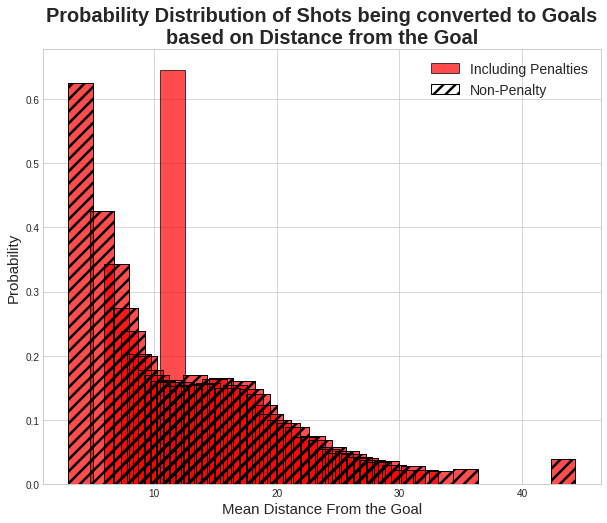

In [ ]:
# Plotting the disitributions calculated
mpl.rcParams['hatch.linewidth']=2.5
fig,axs = plt.subplots(figsize=(10,8))
plt.bar(dfVizDistanceBins['meanDistance'],dfVizDistanceBins['isGoal'],width=2,color='red',edgecolor='k',alpha=.7,label='Including Penalties')
plt.bar(dfNPDistanceBins['meanDistance'],dfNPDistanceBins['isGoal'],width=2,edgecolor='k',color='None',hatch='//',label='Non-Penalty')
plt.xlabel('Mean Distance From the Goal',fontsize=15)
plt.ylabel('Probability',fontsize=15)

plt.title('Probability Distribution of Shots being converted to Goals\nbased on Distance from the Goal',fontsize=20,fontweight='bold')
plt.legend(fontsize=14)

plt.show()

**Inference** : <br>
* The probability of a shot being a goal increases as the distance from goal decreases almost exponetially.
* A sudden spike around 11 units mark is because of the high conversion rate of shots which are penalties. However, if we only observe Non-Penalty shots (i.e, bars with pattern) we can see the pattern much clearly.

In [ ]:
# Binning Shot Angles
dfViz['AngleBins'] = pd.qcut(dfViz['Angle'],q=50)
dfNP = dfViz[dfViz['situation']!='Penalty'] # DataFrame of Goals which aren't from Penalties
dfVizAngleBins = dfViz.groupby('AngleBins')['isGoal'].mean().reset_index() # Grouping by the bin and calculating average goals scored in that bin
dfVizAngleBins['meanAngle'] = dfViz.groupby('AngleBins',as_index=False)['Angle'].mean()['Angle'] # Calculating mean angle for each bin

In [ ]:
# Similarly calculating average goals and mean shot angle for each bin with Non penalty data
dfNPAngleBins = dfNP.groupby('AngleBins')['isGoal'].mean().reset_index()
dfNPAngleBins['meanAngle'] = dfNP.groupby('AngleBins',as_index=False)['Angle'].mean()['Angle']

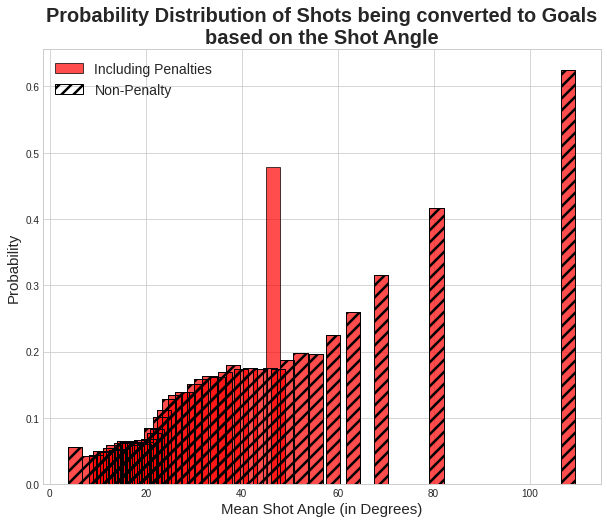

In [ ]:
# Plotting the disitributions calculated
mpl.rcParams['hatch.linewidth']=2.5
fig,axs = plt.subplots(figsize=(10,8))
plt.bar(dfVizAngleBins['meanAngle'],dfVizAngleBins['isGoal'],width=3,color='red',edgecolor='k',alpha=.7,label='Including Penalties')
plt.bar(dfNPAngleBins['meanAngle'],dfNPAngleBins['isGoal'],width=3,edgecolor='k',color='None',hatch='//',label='Non-Penalty')
plt.xlabel('Mean Shot Angle (in Degrees)',fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.title('Probability Distribution of Shots being converted to Goals\nbased on the Shot Angle',fontsize=20,fontweight='bold')
plt.legend(fontsize=14)
plt.show()

**Inference** : <br>
* The probability of a shot being a goal increases as the shot angle increases.
* A sudden spike around 45 degrees mark is because of the high conversion rate of shots which are penalties. However, if we only observe Non-Penalty shots (i.e, bars with pattern) we can see the trend much clearly.

In [ ]:
# Creating custom colormap
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#2b2b2b', '#ff0000'])

In [ ]:
# Creating a pitch object from mplsoccer to plot the pitches
vertPitch = VerticalPitch(pitch_type='opta',line_color='#ffffff',line_zorder=2,
                          pitch_color='#2b2b2b',half=True,goal_type='box',
                          pad_top=0.05, pad_right=0.05,
                          pad_left=0.05,pad_bottom=0)

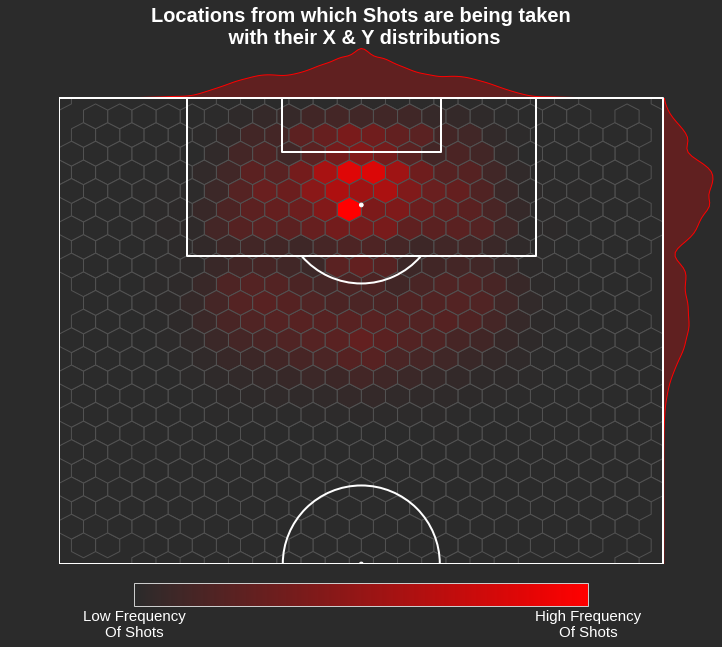

In [ ]:
# Plotting the pitch along with joingrid
fig, axs = vertPitch.jointgrid(left=None,bottom=0.075, grid_height=0.8,
                           axis=False,  
                           endnote_height=0, title_height=0) 
fig.set_facecolor('#2b2b2b')
# Plotting HexMap and X & Y distributions 
hexmap = vertPitch.hexbin(dfViz['X'],dfViz['Y'],
                          ax=axs['pitch'],gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap)
sns.kdeplot(y=dfViz.X, ax=axs['right'],color='#ff0000',shade=True)
sns.kdeplot(x=dfViz.Y, ax=axs['top'],color='#ff0000',shade=True)

fig.suptitle(y=.935,t='Locations from which Shots are being taken\n with their X & Y distributions',color='w',fontsize=20,fontweight='bold')

# Creating axes to plot colorbar
ax2 = fig.add_axes([0.1,0.01,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)

# Plotting colorbar
cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low Frequency\nOf Shots','High Frequency\nOf Shots'],color='w')


plt.show()

**Inference** : <br>
* There are shots taken from almost every location in opposition half.
* However, most of shots come from inside the box near the penalty spot.
* Shots are taken from the outside the front of penalty box as well, but very less frequently when compared to shots in the box. 

In [ ]:
customcmap1 = LinearSegmentedColormap.from_list('custom cmap', ['#2b2b2b', '#ff0000', '#ff0000'])

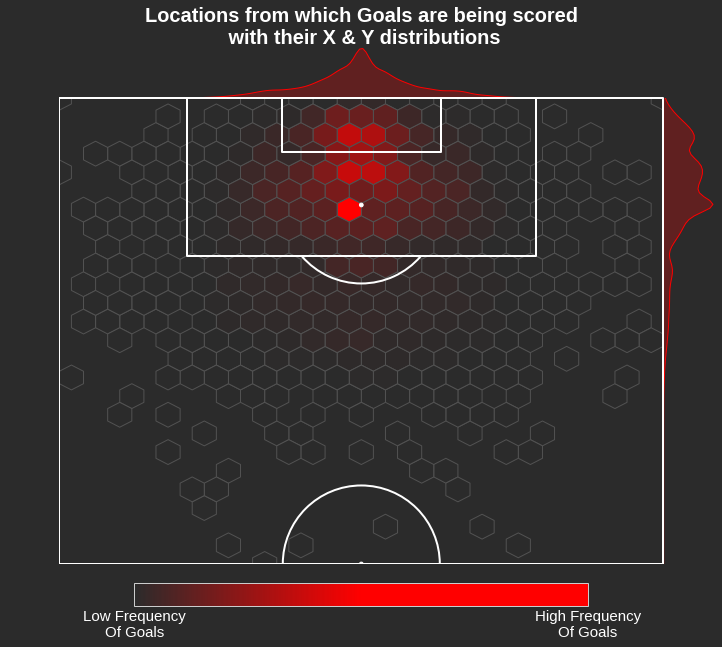

In [ ]:
# Plotting the pitch along with joingrid
fig, axs = vertPitch.jointgrid(left=None,bottom=0.075, grid_height=0.8,
                           axis=False,  
                           endnote_height=0, title_height=0)
fig.set_facecolor('#2b2b2b')
# Plotting HexMap and X & Y distributions 
hexmap = vertPitch.hexbin(dfGViz['X'],dfGViz['Y'],
                          ax=axs['pitch'],gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap1)
sns.kdeplot(y=dfGViz.X, ax=axs['right'],color='#ff0000',shade=True)
sns.kdeplot(x=dfGViz.Y, ax=axs['top'],color='#ff0000',shade=True)

fig.suptitle(y=.935,t='Locations from which Goals are being scored\n with their X & Y distributions',color='w',fontsize=20,fontweight='bold')

# Creating axes to plot colorbar
ax2 = fig.add_axes([0.1,0.01,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)

# Plotting colorbar
cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low Frequency\nOf Goals','High Frequency\nOf Goals'],color='w')

plt.show()

**Inference** : <br>
* Most of the goals come from the central locations inside the goal-box near the penalty spot.
* Goals are scored from outside the box as well, but their frequency extremely rare, when compared to the frequency of goals being scored inside the box.

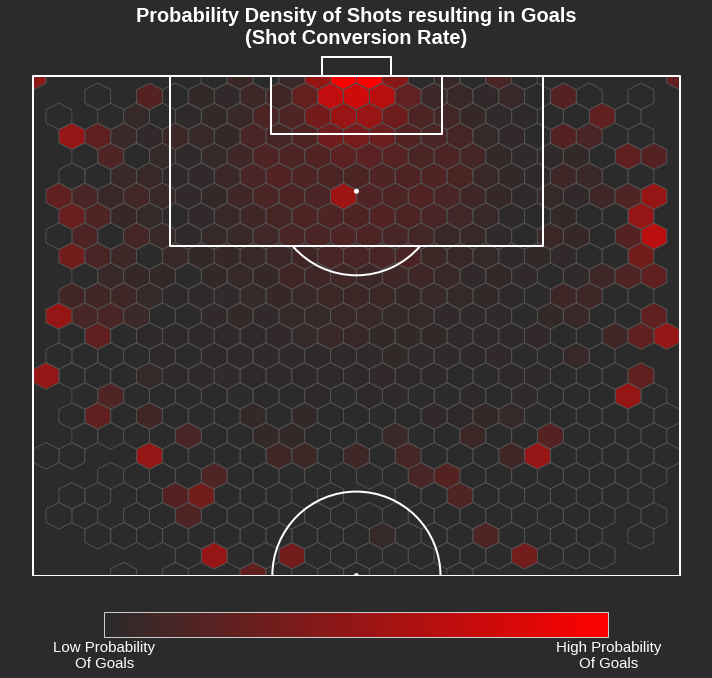

In [ ]:
# Storing all the isGoal values to calculate probability
prob = np.array(dfViz['isGoal'])
# Creating a pitch object
pitch = VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white',goal_type='box',line_zorder=2,half=True,pad_bottom=0) 
# Plotting the pitch
fig, ax = pitch.draw(figsize=(10,10))
fig.set_facecolor('#2b2b2b')
# Plotting the HexMap with Probability of Goals being scored based on Shot Location
hexmap = pitch.hexbin(dfViz['X'],dfViz['Y'],C=prob,reduce_C_function=np.mean,
                          ax=ax,gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap)

fig.suptitle(y=.925,t='Probability Density of Shots resulting in Goals\n(Shot Conversion Rate)',color='w',fontsize=20,fontweight='bold')

# Creating axes to plot colorbar
ax2 = fig.add_axes([0.1,0.05,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)

# Plotting colorbar
cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low Probability\nOf Goals','High Probability\nOf Goals'],color='w')


plt.show()

**Inference** : <br>
As expected, basing on our previous findings in the EDA, a shot is highly likely to be a goal if the shot is taken closer to the goal, since the Distance from the Goal will be low and the Shot Angle will be high.<br>
We can notice there are a few outliers near the edges of the pitch, this is because the shots from these locations are rarely taken and some of them might end-up catching the Goal Keeper off-guard.

# Modeling

In [ ]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,match_id,h_team,a_team,h_goals,a_goals,date,lastAction,isGoal,Angle,DistanceFromGoal
1,378458.0,54,MissedShots,87.800003,43.000000,0.031428,Ollie Watkins,h,8865,OpenPlay,...,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Cross,0,35.216557,14.065558
2,378464.0,77,MissedShots,85.800003,67.900002,0.060696,Ollie Watkins,h,8865,OpenPlay,...,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Pass,0,15.943871,22.848413
3,379954.0,34,MissedShots,83.099998,65.500000,0.127710,Ollie Watkins,a,8865,OpenPlay,...,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,TakeOn,0,18.645405,22.931639
4,379956.0,46,MissedShots,94.300003,50.000000,0.445354,Ollie Watkins,a,8865,FromCorner,...,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Cross,0,82.514054,5.699997
5,381490.0,3,Goal,91.599998,52.400002,0.510213,Ollie Watkins,h,8865,OpenPlay,...,14466,Aston Villa,Liverpool,7,2,2020-10-04 18:15:00,Pass,1,58.577045,8.736134


Since we do not know the information if the player is using preferred foot or unpreferred foot while taking the shot, we change the `RightFoot` and `LeftFoot` values in the `shotType` column to `Foot`.

In [ ]:
df['shotType'] = np.where(df['shotType']=='LeftFoot','Foot',df['shotType'])
df['shotType'] = np.where(df['shotType']=='RightFoot','Foot',df['shotType'])

Selecting the Predictor and Response variables for the model

In [ ]:
X = df[['X','Y','situation','shotType','lastAction','Angle','DistanceFromGoal']]
y = df['isGoal']

Encoding the Categorical Variables using One-Hot Encoding

In [ ]:
columnsOHE = X.select_dtypes(include='object').columns.to_list()

In [ ]:
listOHE = []
for column in columnsOHE:
    listOHE.append(pd.get_dummies(X[column]))

In [ ]:
dfOHE = pd.concat(listOHE,axis=1)

In [ ]:
X = X.drop(columns=columnsOHE) # Dropping the categorical variables

In [ ]:
X = pd.concat([X,dfOHE],axis=1) # Concating the one-hot encoded variables

Using `train_test_split` to make the training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=10,stratify=y)

## Base Model

### Decision Tree algorithm

**Vanilla Decision Tree**

In [ ]:
dtree = DecisionTreeClassifier(random_state=23) # Loading the Decision Tree Classifier

In [ ]:
dtree.fit(X_train,y_train) # Fitting on the training data

DecisionTreeClassifier(random_state=23)

In [ ]:
y_train_dt = dtree.predict(X_train) # Predicting on the training data
y_test_dt = dtree.predict(X_test) # Predicting on the testing data
y_prob_dt = dtree.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

**Performance Metrics**

In [ ]:
print('Accuracy of the Vanilla Decision Tree Classifier on the Training Data : {:.4f} %'.format(accuracy_score(y_train,y_train_dt)*100))
print('Accuracy of the Vanilla Decision Tree Classifier on the Testing Data : {:.4f} %'.format(accuracy_score(y_test,y_test_dt)*100))

Accuracy of the Vanilla Decision Tree Classifier on the Training Data : 97.2781 %
Accuracy of the Vanilla Decision Tree Classifier on the Testing Data : 81.6218 %


In [ ]:
print('ROC-AUC score of the Vanilla Decision Tree Classifier : {:.4f}'.format(roc_auc_score(y_test,y_prob_dt)))

ROC-AUC score of the Vanilla Decision Tree Classifier : 0.6289


**Finding the best `max_depth` value of the Decision Tree**

In [ ]:
# Using cross-validation to find the best max_depth value
accuracyVal = {}
accuracyTrain = {}
for i in range(1,10):
    dtree_x = DecisionTreeClassifier(max_depth=i)
    cv = cross_validate(dtree_x,X_train,y_train,scoring='accuracy',return_train_score=True,cv=10)
    accuracyVal[i] = cv['test_score'].mean()
    accuracyTrain[i] = cv['train_score'].mean()


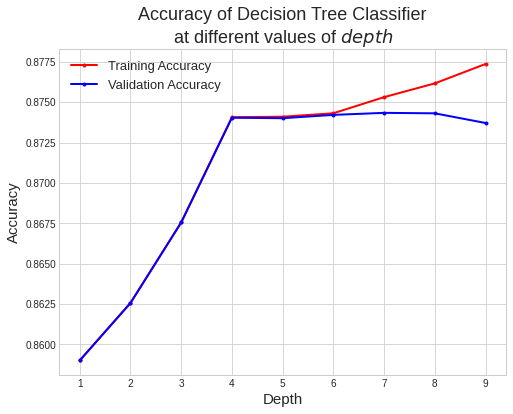

In [ ]:
# Plotting Train and Validation accuracies
plt.figure(figsize=(8,6))
plt.plot(list(accuracyTrain.keys()),list(accuracyTrain.values()),'r.-',lw=2,label='Training Accuracy')
plt.plot(list(accuracyVal.keys()),list(accuracyVal.values()),'b.-',lw=2,label='Validation Accuracy')
plt.title('Accuracy of Decision Tree Classifier\nat different values of $depth$',fontsize=18)
plt.xlabel('Depth',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=13)
plt.show()

The validation accuracy stops increasing after a depth of 7.

In [ ]:
# Assigning the best max_depth value as max_depth with best validation accuracy
bestDepth = [key for (key,value) in accuracyVal.items() if value==max(accuracyVal.values())][0]

In [ ]:
print('The best max_depth value of Decision Tree classifier : ',bestDepth)

The best max_depth value of Decision Tree classifier :  7


**Decision Tree with best `max_depth` value**

In [ ]:
# Creating a Decision Tree with best max_depth
dtreeBest = DecisionTreeClassifier(max_depth=bestDepth)

In [ ]:
# Fitting on the Training Data
dtreeBest.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7)

In [ ]:
y_train_dtree = dtreeBest.predict(X_train) # Predicting on the training data
y_test_dtree = dtreeBest.predict(X_test) # Predicting on the testing data
y_prob_dtree = dtreeBest.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

**Performance Metrics**

In [ ]:
print('Training Accuracy of the Decision Tree Classifier with best max_depth value : {:.4f} %'.format(accuracy_score(y_train,y_train_dtree)*100))
print('Testing Accuracy of the Decision Tree Classifier with best max_depth value  : {:.4f} %'.format(accuracy_score(y_test,y_test_dtree)*100))

Training Accuracy of the Decision Tree Classifier with best max_depth value : 87.5151 %
Testing Accuracy of the Decision Tree Classifier with best max_depth value  : 87.6095 %


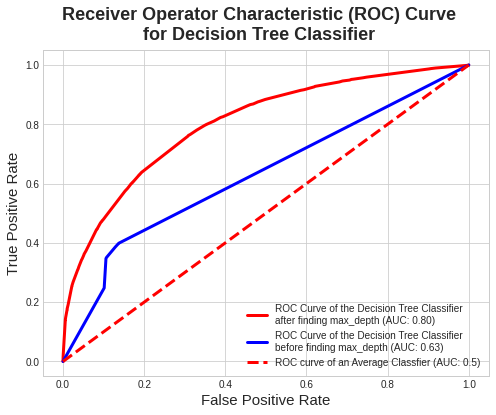

In [ ]:
# Plotting the ROC curve for Decision Tree Classifier
fig,ax = plt.subplots(figsize=(8,6))

ns_fpr = [0,1]
ns_tpr = [0,1]
plot_roc_curve(dtreeBest, X_test, y_test, color='red',linewidth=3,\
                label='ROC Curve of the Decision Tree Classifier\nafter finding max_depth (AUC: {:.2f})'.format(roc_auc_score(y_test,y_prob_dtree)),ax=ax)
plot_roc_curve(dtree, X_test, y_test, color='blue',linewidth=3,\
                label='ROC Curve of the Decision Tree Classifier\nbefore finding max_depth (AUC: {:.2f})'.format(roc_auc_score(y_test,y_prob_dt)), ax=ax)
ax.plot(ns_fpr, ns_tpr, linestyle='--',color='r',lw=3,label='ROC curve of an Average Classfier (AUC: 0.5)')
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15) 
ax.legend(loc='lower right') 

fig.suptitle('Receiver Operator Characteristic (ROC) Curve\nfor Decision Tree Classifier',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
print('ROC-AUC score of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.4f}'.format(roc_auc_score(y_test,y_prob_dtree)))

ROC-AUC score of the Decision Tree Classifier after Hyper-Parameter Tuning : 0.8018


There is a significant imporvement in ROC-AUC value before and after finding the best `max_depth` value

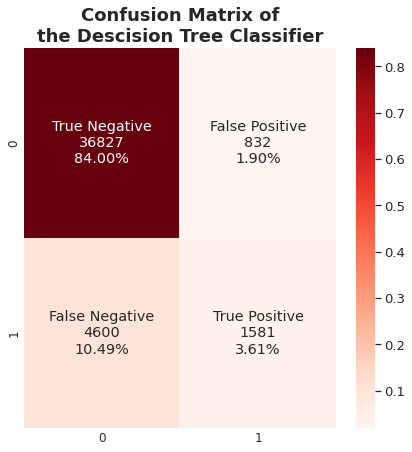

In [ ]:
# Plotting Confusion Matrix
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_dtree)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix of\nthe Descision Tree Classifier',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
precision_dtree = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr_dtree = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [ ]:
print('Precision of the Decision Tree Classifier after finding the best max_depth : {:.2f} %'.format(precision_dtree*100))
print('False Positive Rate of the Decision Tree Classifier after finding the best max_depth : {:.2f} %'.format(fpr_dtree*100))

Precision of the Decision Tree Classifier after finding the best max_depth : 65.52 %
False Positive Rate of the Decision Tree Classifier after finding the best max_depth : 2.21 %


In [ ]:
print('F1 Score of the Decision Tree Classifier after Hyper-Parameter Tuning : {:.2f}'.format(f1_score(y_test,y_test_dtree)))

F1 Score of the Decision Tree Classifier after Hyper-Parameter Tuning : 0.37


**Visualizing the Decision Tree**

The following code to visualize the Decision Tree is taken from this Stack Overflow link, <br>
https://stackoverflow.com/questions/31209016/python-pydot-and-decisiontreebold 

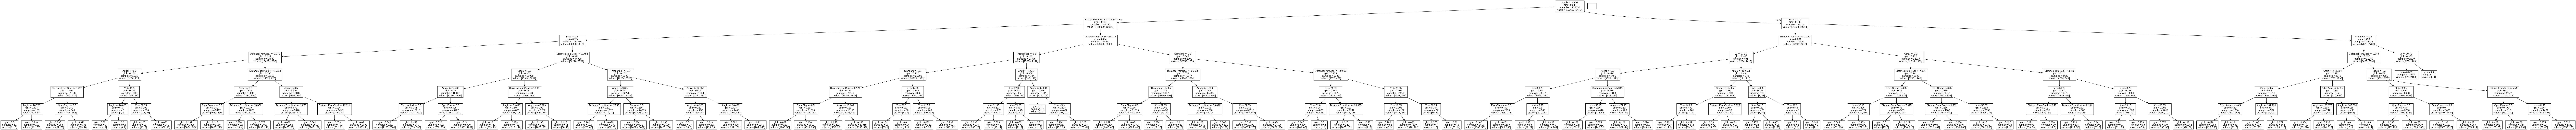

In [ ]:
dot_data = StringIO()
tree.export_graphviz(dtreeBest, out_file=dot_data,feature_names=X.columns)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

In [ ]:
graph[0].write_png("DTree.png")

## Ensemble Models

### Random Forest Classifier

**Hyper-parameter Tuning**

Commenting out the following code with GridSearch for Hyperparameter Tuning because of the time complexity and including the snippet of the code with the tuned hyper-parameter values.

In [ ]:
'''
# Assigning parameters to perform Grid-Search on
params = {'n_estimators' : [50,100,200,400],'criterion': ['gini', 'entropy'],'max_depth':[5,6,7,8,9,10]}

# Creating a Random Forest Model to perform Grid Search with
rf = RandomForestClassifier(random_state=23)

# Creating the GridSearch object 
clf = GridSearchCV(rf,params,cv=5,return_train_score=True,scoring='accuracy',n_jobs=-1)

# Fitting it on the training data
clf.fit(X_train,y_train)
'''

"\n# Assigning parameters to perform Grid-Search on\nparams = {'n_estimators' : [50,100,200,400],'criterion': ['gini', 'entropy'],'max_depth':[5,6,7,8,9,10]}\n\n# Creating a Random Forest Model to perform Grid Search with\nrf = RandomForestClassifier(random_state=23)\n\n# Creating the GridSearch object \nclf = GridSearchCV(rf,params,cv=5,return_train_score=True,scoring='accuracy',n_jobs=-1)\n\n# Fitting it on the training data\nclf.fit(X_train,y_train)\n"

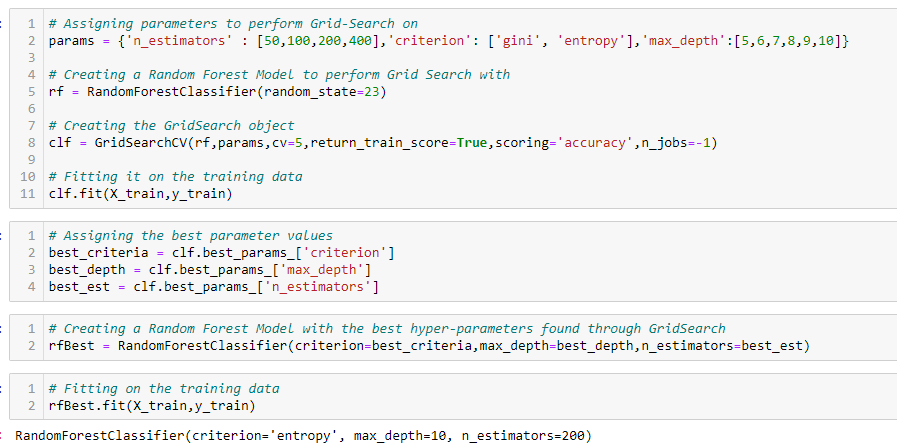

In [ ]:
# Creating a Random Forest Model with the best hyper-parameters found through GridSearch
rfBest = RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200, random_state=23)

In [ ]:
# Fitting on the training data
rfBest.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       random_state=23)

In [ ]:
y_train_rf = rfBest.predict(X_train) # Predicting on the training data
y_test_rf = rfBest.predict(X_test) # Predicting on the testing data
y_prob_rf = rfBest.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

In [ ]:
print('Training Accuracy of the Random Forest Classifier after hyper-parameter tuning : {:.4f} %'.format(accuracy_score(y_train,y_train_rf)*100))
print('Testing Accuracy of the Random Forest Classifier after hyper-parameter tuning : {:.4f} %'.format(accuracy_score(y_test,y_test_rf)*100))

Training Accuracy of the Random Forest Classifier after hyper-parameter tuning : 87.6691 %
Testing Accuracy of the Random Forest Classifier after hyper-parameter tuning : 87.7441 %


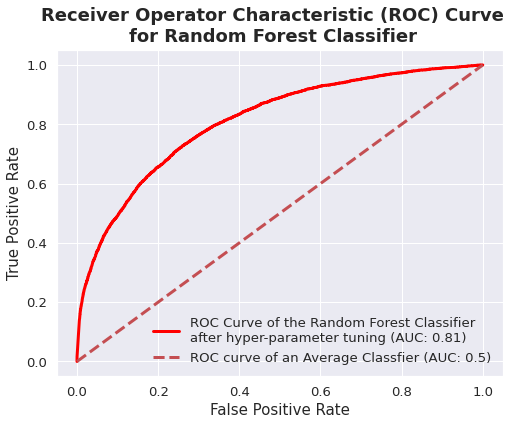

In [ ]:
# Plotting the ROC curve for Random Forest Classifier
fig,ax = plt.subplots(figsize=(8,6))

ns_fpr = [0,1]
ns_tpr = [0,1]
plot_roc_curve(rfBest, X_test, y_test, color='red',linewidth=3,\
                label='ROC Curve of the Random Forest Classifier\nafter hyper-parameter tuning (AUC: {:.2f})'.format(roc_auc_score(y_test,y_prob_rf)),ax=ax)
ax.plot(ns_fpr, ns_tpr, linestyle='--',color='r',lw=3,label='ROC curve of an Average Classfier (AUC: 0.5)')
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15) 
ax.legend(loc='lower right') 

fig.suptitle('Receiver Operator Characteristic (ROC) Curve\nfor Random Forest Classifier',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
print('ROC-AUC score of the Random Forest Classifier after Hyper-Parameter Tuning : {:.4f}'.format(roc_auc_score(y_test,y_prob_rf)))

ROC-AUC score of the Random Forest Classifier after Hyper-Parameter Tuning : 0.8101


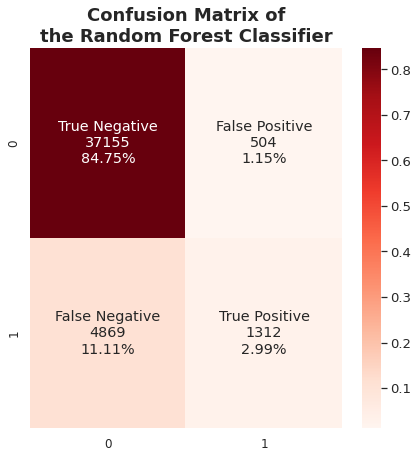

In [ ]:
# Plotting Confusion Matrix
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_rf)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix of\nthe Random Forest Classifier',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
precision_rf = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr_rf = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [ ]:
print('Precision of the Random Forest Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(precision_rf*100))
print('False Positive Rate of the Random Forest Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(fpr_rf*100))

Precision of the Random Forest Classifier after Hyper-Parameter Tuning : 72.25 %
False Positive Rate of the Random Forest Classifier after Hyper-Parameter Tuning : 1.34 %


In [ ]:
print('F1 Score of the Random Forest Classifier after Hyper-Parameter Tuning : {:.2f}'.format(f1_score(y_test,y_test_rf)))

F1 Score of the Random Forest Classifier after Hyper-Parameter Tuning : 0.33


### AdaBoost Classifier

Commenting out the following code with GridSearch for Hyperparameter Tuning because of the time complexity and including the snippet of the code with the tuned hyper-parameter values.

In [ ]:
'''
# Assigning parameters to perform Grid-Search on
parameters = {'base_estimator__max_depth':[5,6,7,8,9,10],
              'base_estimator__criterion': ['gini', 'entropy'],
              'n_estimators':np.linspace(100,500,5).astype(int),
              'learning_rate':[0.01,0.1,1,5]}

# Creating a Ada Boost Classifier Model to perform Grid Search with
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=23)

# Creating the GridSearch object 
clf = GridSearchCV(adaboost, parameters,scoring='roc_auc',n_jobs=-1)

# Fitting it on the training data
clf.fit(X_train,y_train)

# Best parameters according to GridSearch
clf.best_params_
'''

"\n# Assigning parameters to perform Grid-Search on\nparameters = {'base_estimator__max_depth':[5,6,7,8,9,10],\n              'base_estimator__criterion': ['gini', 'entropy'],\n              'n_estimators':np.linspace(100,500,5).astype(int),\n              'learning_rate':[0.01,0.1,1,5]}\n\n# Creating a Ada Boost Classifier Model to perform Grid Search with\nadaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=23)\n\n# Creating the GridSearch object \nclf = GridSearchCV(adaboost, parameters,scoring='roc_auc',n_jobs=-1)\n\n# Fitting it on the training data\nclf.fit(X_train,y_train)\n\n# Best parameters according to GridSearch\nclf.best_params_\n"

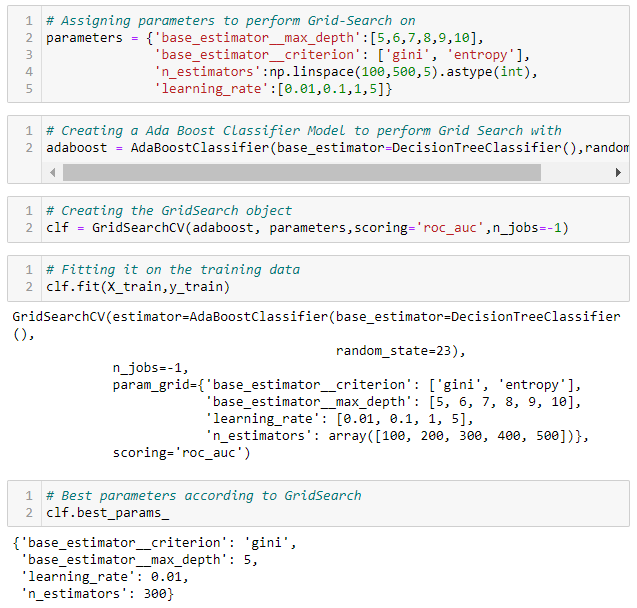

In [ ]:
# Creating a AdaBoost Classifier with the best hyper-parameters found through GridSearch
adaboostBest = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',max_depth=5),
                                  learning_rate=0.01, n_estimators=300, random_state=23)

In [ ]:
# Fitting on the training data
adaboostBest.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.01, n_estimators=300, random_state=23)

In [ ]:
y_train_ab = adaboostBest.predict(X_train) # Predicting on the training data
y_test_ab = adaboostBest.predict(X_test) # Predicting on the testing data
y_prob_ab = adaboostBest.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

In [ ]:
print('Training Accuracy of the AdaBoost Classifier after hyper-parameter tuning : {:.4f} %'.format(accuracy_score(y_train,y_train_ab)*100))
print('Testing Accuracy of the AdaBoost Classifier after hyper-parameter tuning : {:.4f} %'.format(accuracy_score(y_test,y_test_ab)*100))

Training Accuracy of the AdaBoost Classifier after hyper-parameter tuning : 87.5807 %
Testing Accuracy of the AdaBoost Classifier after hyper-parameter tuning : 87.7349 %


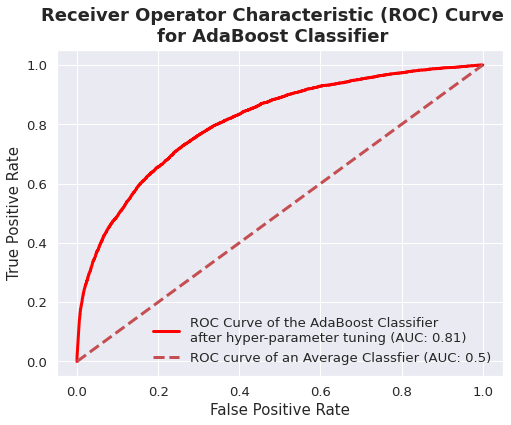

In [ ]:
# Plotting the ROC curve for AdaBoost Classifier
fig,ax = plt.subplots(figsize=(8,6))

ns_fpr = [0,1]
ns_tpr = [0,1]
plot_roc_curve(rfBest, X_test, y_test, color='red',linewidth=3,\
               label='ROC Curve of the AdaBoost Classifier\nafter hyper-parameter tuning (AUC: {:.2f})'.format(roc_auc_score(y_test,y_prob_ab)),ax=ax)
ax.plot(ns_fpr, ns_tpr, linestyle='--',color='r',lw=3,label='ROC curve of an Average Classfier (AUC: 0.5)')
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15) 
ax.legend(loc='lower right') 

fig.suptitle('Receiver Operator Characteristic (ROC) Curve\nfor AdaBoost Classifier',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
print('ROC-AUC score of the AdaBoost Classifier after Hyper-Parameter Tuning : {:.4f}'.format(roc_auc_score(y_test,y_prob_ab)))

ROC-AUC score of the AdaBoost Classifier after Hyper-Parameter Tuning : 0.8097


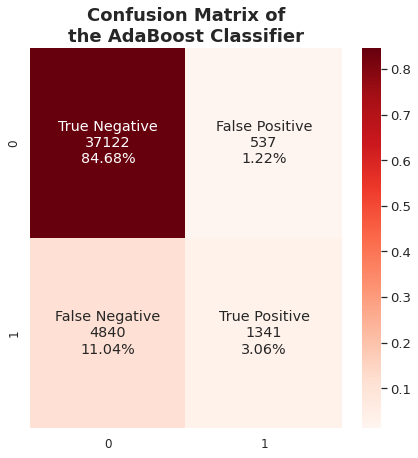

In [ ]:
# Plotting Confusion Matrix
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_ab)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix of\nthe AdaBoost Classifier',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
precision_ab = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr_ab = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [ ]:
print('Precision of the AdaBoost Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(precision_ab*100))
print('False Positive Rate of the AdaBoost Classifier after Hyper-Parameter Tuning : {:.2f} %'.format(fpr_ab*100))

Precision of the AdaBoost Classifier after Hyper-Parameter Tuning : 71.41 %
False Positive Rate of the AdaBoost Classifier after Hyper-Parameter Tuning : 1.43 %


In [ ]:
print('F1 Score of the AdaBoost Classifier after Hyper-Parameter Tuning : {:.2f}'.format(f1_score(y_test,y_test_ab)))

F1 Score of the AdaBoost Classifier after Hyper-Parameter Tuning : 0.33


In [ ]:
# Creating a table with Performance Matrics of models to compare
pt = PrettyTable()
pt.field_names = ['Classifier','Accuracy','ROC-AUC','Precision','FPR','F1-Score']
pt.add_row(['Decision Tree',round(accuracy_score(y_test,y_test_dt)*100,2),round(roc_auc_score(y_test,y_prob_dt),2),
            str(round(precision_dtree*100,2))+'%',str(round(fpr_dtree*100,2))+'%',round(f1_score(y_test,y_test_dt),2)])
pt.add_row(['Random Forest',round(accuracy_score(y_test,y_test_rf)*100,2),round(roc_auc_score(y_test,y_prob_rf),2),
            str(round(precision_rf*100,2))+'%',str(round(fpr_rf*100,2))+'%',round(f1_score(y_test,y_test_rf),2)])
pt.add_row(['AdaBoost',round(accuracy_score(y_test,y_test_ab)*100,2),round(roc_auc_score(y_test,y_prob_ab),2),
            str(round(precision_ab*100,2))+'%',str(round(fpr_ab*100,2))+'%',round(f1_score(y_test,y_test_ab),2)])

print(pt)

+---------------+----------+---------+-----------+-------+----------+
|   Classifier  | Accuracy | ROC-AUC | Precision |  FPR  | F1-Score |
+---------------+----------+---------+-----------+-------+----------+
| Decision Tree |  81.62   |   0.63  |   65.52%  | 2.21% |   0.35   |
| Random Forest |  87.74   |   0.81  |   72.25%  | 1.34% |   0.33   |
|    AdaBoost   |  87.73   |   0.81  |   71.41%  | 1.43% |   0.33   |
+---------------+----------+---------+-----------+-------+----------+


From the classifiers made so far, <br>
we can see that the ensemble models (Random Forest and AdaBoost) outperform the base model (Decision Tree) in all the metrics except the F1-score.<br>
This is likely because of the imbalanced classes in the dataset.<br>
To solve this problem, we'll be using Random Forest with `class_weighting` along with SMOTE to upsample the data 

## Handling Class Imbalance

**Using SMOTE**

In [ ]:
# Creating a SMOTE object to upsample the data
sm = SMOTE(random_state=23)

In [ ]:
# Using the SMOTE object to upsample the training data
X_train_up, y_train_up = sm.fit_resample(X_train,y_train)

In [ ]:
# Creating a Random Forest Model with the best hyper-parameters found through GridSearch along with class_weightage
rfSMOTE = RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,class_weight='balanced_subsample',random_state=23)

In [ ]:
# Fitting on the upsampled train data
rfSMOTE.fit(X_train_up, y_train_up)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, n_estimators=200, random_state=23)

In [ ]:
y_test_rfsm = rfSMOTE.predict(X_test) # Predicting on the testing data
y_prob_rfsm = rfSMOTE.predict_proba(X_test)[:,1] # Predicting the probabilities on test data

**Performance Metrics**

In [ ]:
print('Testing Accuracy of the Random Forest Classifier after hyper-parameter tuning, along with Class Weightage and SMOTE : {:.4f} %'.format(accuracy_score(y_test,y_test_rfsm)*100))

Testing Accuracy of the Random Forest Classifier after hyper-parameter tuning, along with Class Weightage and SMOTE : 74.2678 %


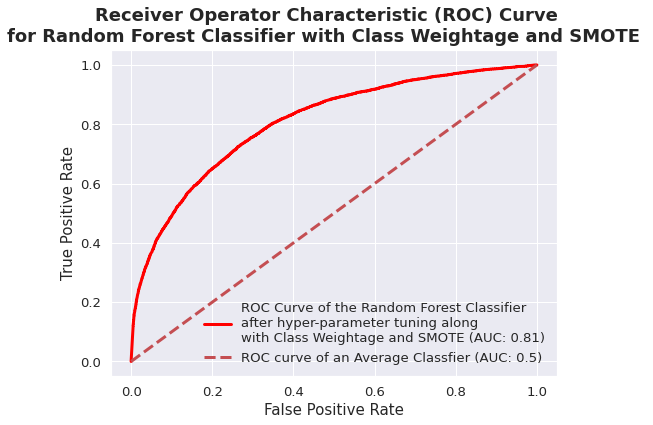

In [ ]:
# Plotting the ROC curve for Random Forest Classifier after hyper-parameter tuning, along with Class Weightage and SMOTE
fig,ax = plt.subplots(figsize=(8,6))

ns_fpr = [0,1]
ns_tpr = [0,1]
plot_roc_curve(rfSMOTE, X_test, y_test, color='red',linewidth=3,\
               label='ROC Curve of the Random Forest Classifier\nafter hyper-parameter tuning along\nwith Class Weightage and SMOTE (AUC: {:.2f})'.format(roc_auc_score(y_test,y_prob_rfsm)),ax=ax)
ax.plot(ns_fpr, ns_tpr, linestyle='--',color='r',lw=3,label='ROC curve of an Average Classfier (AUC: 0.5)')
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15) 
ax.legend(loc='lower right') 

fig.suptitle('Receiver Operator Characteristic (ROC) Curve\nfor Random Forest Classifier with Class Weightage and SMOTE ',fontsize=18,fontweight='bold')

plt.show()

In [ ]:
print('ROC-AUC score of the Random Forest Classifier after hyper-parameter tuning along with Class Weightage and SMOTE : {:.4f}'.format(roc_auc_score(y_test,y_prob_rfsm)))

ROC-AUC score of the Random Forest Classifier after hyper-parameter tuning along with Class Weightage and SMOTE : 0.8066


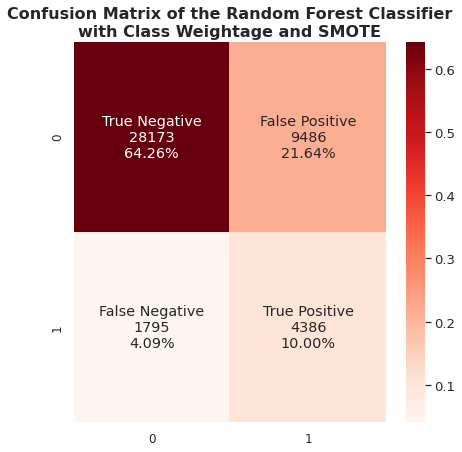

In [ ]:
# Plotting Confusion Matrix
fig,ax = plt.subplots(figsize=(7,7))

conf_matrix = confusion_matrix(y_test, y_test_rfsm)
names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{}'.format(value) for value in conf_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix/np.sum(conf_matrix),fmt='',cmap='Reds',ax=ax,annot=labels)
ax.tick_params(axis='both', which='major', labelsize=12) 

plt.title('Confusion Matrix of the Random Forest Classifier\nwith Class Weightage and SMOTE',fontsize=16,fontweight='bold')

plt.show()

In [ ]:
precision_rfsm = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
fpr_rfsm = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])

In [ ]:
print('Precision of the Random Forest Classifier with Class Weightage and SMOTE : {:.2f} %'.format(precision_rfsm*100))
print('False Positive Rate of the Random Forest Classifier with Class Weightage and SMOTE : {:.2f} %'.format(fpr_rfsm*100))

Precision of the Random Forest Classifier with Class Weightage and SMOTE : 31.62 %
False Positive Rate of the Random Forest Classifier with Class Weightage and SMOTE : 25.19 %


In [ ]:
print('F1 Score of the Random Forest Classifier with Class Weightage and SMOTE : {:.2f}'.format(f1_score(y_test,y_test_rfsm)))

F1 Score of the Random Forest Classifier with Class Weightage and SMOTE : 0.44


# Interpretation

In [ ]:
# Creating a DataFrame to compare classifiers
dfRes = pd.DataFrame({'Classifier':['Decision Tree','Random Forest','AdaBoost','Random Forest with\nClass Weightage and SMOTE'],
                      'Accuracy':[round(accuracy_score(y_test,y_test_dt)*100,2),round(accuracy_score(y_test,y_test_rf)*100,2),round(accuracy_score(y_test,y_test_ab)*100,2),round(accuracy_score(y_test,y_test_rfsm)*100,2)],
                      'ROC-AUC':[round(roc_auc_score(y_test,y_prob_dt),2),round(roc_auc_score(y_test,y_prob_rf),2),round(roc_auc_score(y_test,y_prob_ab),2),round(roc_auc_score(y_test,y_test_rfsm),2)],
                      'Precision (in %)':[round(precision_dtree*100,2),round(precision_rf*100,2),round(precision_ab*100,2),round(precision_rfsm*100,2)],
                      'FPR (in %)':[round(fpr_dtree*100,2),round(fpr_rf*100,2),round(fpr_ab*100,2),round(fpr_rfsm*100,2)],
                      'F1-Score':[round(f1_score(y_test,y_test_dt),2),round(f1_score(y_test,y_test_rf),2),round(f1_score(y_test,y_test_ab),2),round(f1_score(y_test,y_test_rfsm),2)]})

In [ ]:
# Styling it with colormap based on values
dfRes.style.background_gradient(axis=0)

,Classifier,Accuracy,ROC-AUC,Precision (in %),FPR (in %),F1-Score
0,Decision Tree,81.620000,0.630000,65.520000,2.210000,0.350000
1,Random Forest,87.740000,0.810000,72.250000,1.340000,0.330000
2,AdaBoost,87.730000,0.810000,71.410000,1.430000,0.330000
3,Random Forest with Class Weightage and SMOTE,74.270000,0.730000,31.620000,25.190000,0.440000


After dealing with the class imbalance in the dataset with SMOTE and class weightage, there is a massive dip in Accuracy, Precision and almost a 20x increase in False Positive Rate. <br>
The only silver lining is that the F1-score showed improvement.<br>
However, we do not want the model to positively classify shots as goals when they are not actually goals  at a rate of 25%.<br>
Hence, we are choosing the Random Forest model as our Best Model.

## Feature Importance

In [ ]:
models = [dtreeBest,rfBest,adaboostBest,rfSMOTE]

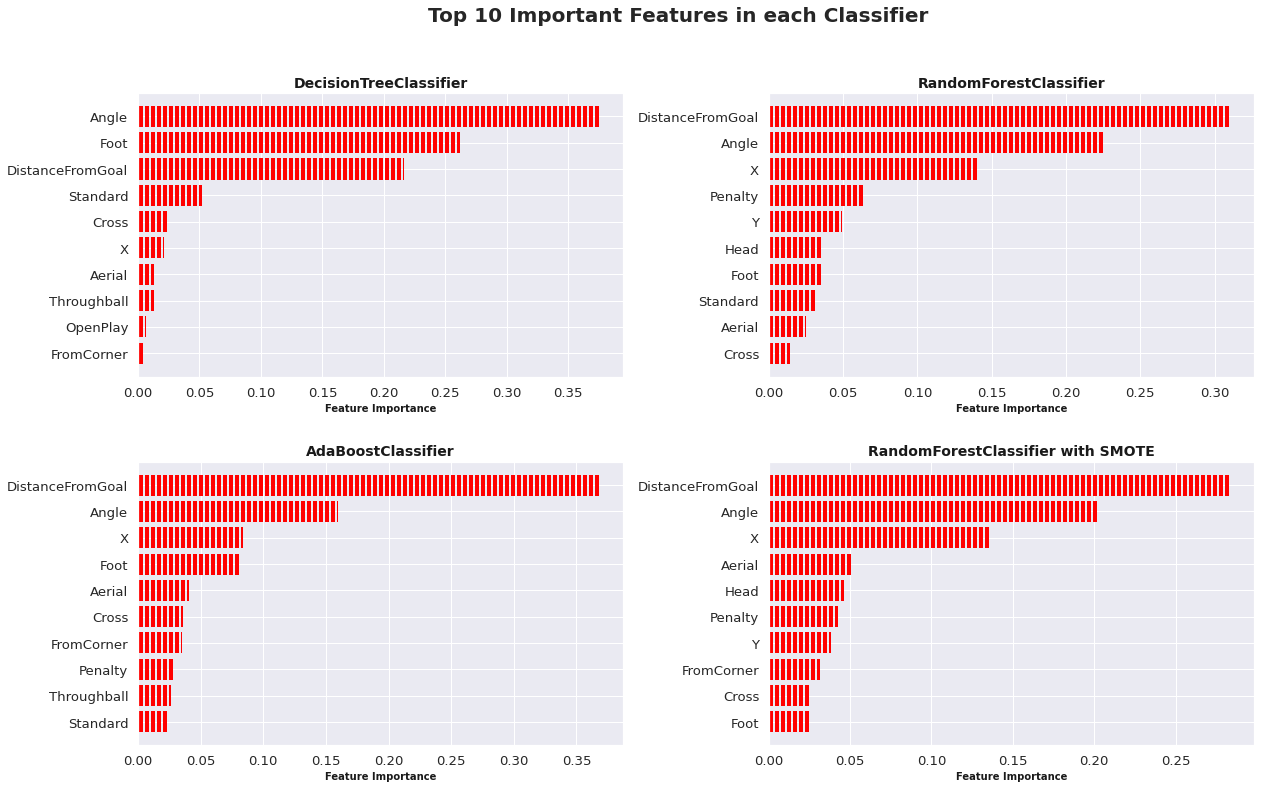

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,12))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
for i,ax in enumerate(axs.flat):
    featImp = models[i].feature_importances_
    dfFeatImp = pd.DataFrame({'FeatureName':X_train.columns,'FeatureImportance':featImp})

    # Sorting the values in dataframe by Feature Importance
    dfFeatImpT5 = dfFeatImp.sort_values(by='FeatureImportance').tail(10)
    mpl.rcParams['hatch.linewidth']=4

    ax.barh(dfFeatImpT5['FeatureName'],dfFeatImpT5['FeatureImportance'],
             color='None',edgecolor='red',hatch='||',lw=0)
    ax.set_xlabel('Feature Importance',fontsize=10,fontweight='bold',color='k')
    ax.set_title(type(models[i]).__name__,fontsize=14,fontweight='bold',color='k')

axs[1][1].set_title('RandomForestClassifier with SMOTE',fontsize=14,fontweight='bold',color='k')
fig.suptitle('Top 10 Important Features in each Classifier',fontsize=20,fontweight='bold')

plt.show()

**Inference**:<br>
* Based on our observations, Shot Angle and Distance from Goal are the two most important features for calculating xG.
* They are present in the top 3 important features in all of the classifiers.
* X value is also present in the top 5 important features of all the ensemble models.
* If the shot comes from a penalty or whether the shot is taken with foot or head are a few other features which are observed in the important features of all the classifiers. 

## Insights from the Model 

In [ ]:
# Creating a dataframe of X_test values before the encoding
dfTest = df[df.index.isin(X_test.index.tolist())]

In [ ]:
# Creating a dataframe of predicted values of Random Forest
dfYval = pd.DataFrame(y_test.values,index=y_test.index,columns=['y_test'])
dfYval['y_pred'] = y_test_rf
dfYval['xG'] = y_prob_rf

In [ ]:
# Merging the two dataframes on index
dfTest = dfTest.merge(dfYval,left_index=True, right_index=True, how='inner')

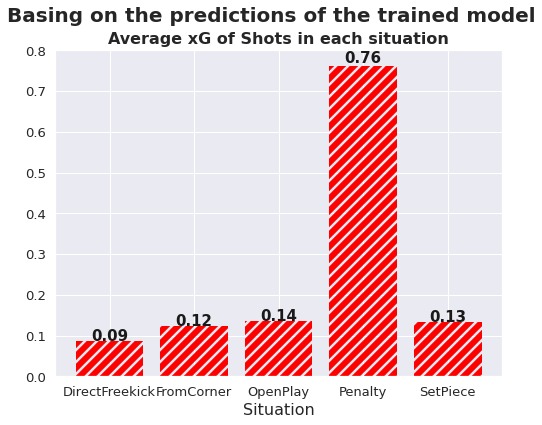

In [ ]:
fig,axs = plt.subplots(figsize=(8,6))
mpl.rcParams['hatch.linewidth'] = 6

# Grouping by situation and calculating mean xG for each situation
xGSit = dfTest.groupby('situation')['xG'].mean().reset_index()

axs.bar(xGSit['situation'],xGSit['xG'],linewidth=0,edgecolor='red',color='None',hatch='//')
axs.set_xlabel('Situation',fontsize=16)
axs.set_xticklabels(xGSit['situation'].values,fontsize=13)
axs.set_title('Average xG of Shots in each situation',fontsize=16,fontweight='bold')
for idx,row in xGSit.iterrows():
    axs.text(xGSit['situation'][idx],xGSit['xG'][idx]+0.01*xGSit['xG'][idx],
                str(round(xGSit['xG'][idx],2)),
                c='k',fontweight='bold',ha='center',size=15)
fig.suptitle('Basing on the predictions of the trained model',fontsize=20,fontweight='bold')

plt.show()

**Inference:**<br>
 
* According to the model, an average xG of a penalty is 0.76. 
* This tallies up with the default peanlty xG value of mainstream data providers like Opta and Statsbomb.
* Average xG of Direct FreeKicks is the least. This adds up with the real world scenario, where direct freekicks are the hardest to score, as they need to be scored from outside the box which increases the distance from the goal and minimizes the shot angle


In [ ]:
customcmap2 = LinearSegmentedColormap.from_list('custom cmap', ['#2b2b2b', '#0390fc'])

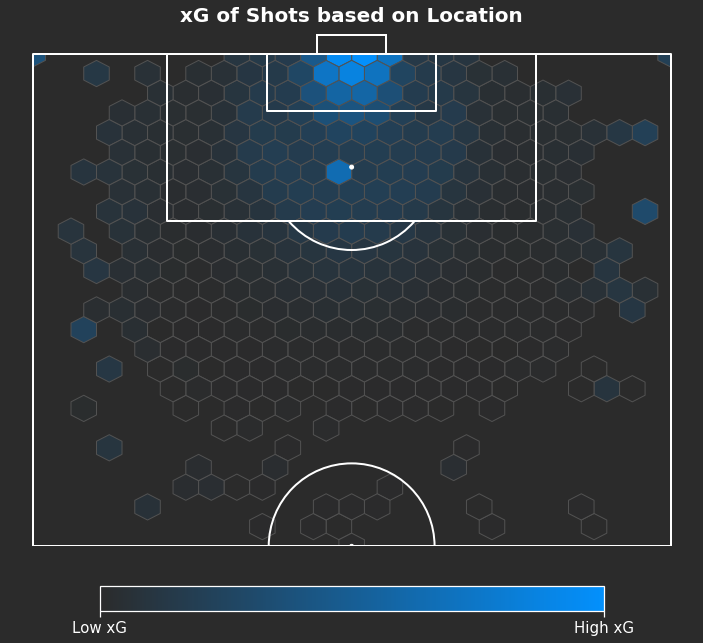

In [ ]:
# Creating and plotting a pitch
pitch = VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white',goal_type='box',line_zorder=2,half=True,pad_bottom=0) 
fig, ax = pitch.draw(figsize=(10,10))
fig.set_facecolor('#2b2b2b')
# Plotting the HexMap on the pitch
hexmap = pitch.hexbin(dfTest['X'],dfTest['Y'],C=dfTest['xG'],
                          ax=ax,gridsize=(25,25),
                          edgecolor='#525252',cmap=customcmap2)
# Setting the title
fig.suptitle(y=.89,t='xG of Shots based on Location',color='w',fontsize=20,fontweight='bold')
# Creating a new axis to plot colorbar
ax2 = fig.add_axes([0.1,0.05,0.8,0.1])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('None')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)
#Plotting colorbar
cbar = plt.colorbar(hexmap,ax=ax2,orientation='horizontal',fraction=.35)
cbar.set_ticks([cbar.vmin,cbar.vmax])
cbar.ax.xaxis.set_tick_params(color='white',labelsize=15)
cbar.ax.set_xticklabels(['Low xG','High xG'],color='w')


plt.show()

**Inference:**<br>
* The xG distribution on the pitch is similar to the Probability distribution plotted earlier.
* Shots closer to the goal have a much higher xG than the ones away from it.

# Conclusions

* Distance From the Goal and Shot Angle are the two key features for predicting if a shot will be a goal.
<br><br>
* As previously mentioned, football is a low scoring game and shots are seldom converted into goals. Hence, any real-time dataset of shots will be imbalanced in-terms of goals.
* The model performed well considering it's high precision and low False Positive Rate.
* However, it has a low F1-score. The number of False Negatives are also high.
* The F1-score and False Negatives can be reduced by using upsampling techniques like SMOTE, but that comes with a trade-off with Precision and FPR.

## Improvements

* Even though Distance From the Goal and Shot Angle are the two key features, there are hundreds of different variables when a shot is taken by a player. In our model, we have only included a few of them.
* By including variables like,
> * Position of the GoalKeeper.
> * If Shot is taken with weak or strong foot.
> * Game State
> * The Locations of other defenders when the shot is taken.
> * Abstract factors like fatigue, morale, confidence of a player etc,<br>

 the model can see some significant improvement.
* Using much more complex models like Neural Networks can also improve the model's performance.







